# Developing Well Calibrated Illness Severity Scores
## Model Analysis
### C.V. Cosgriff, MIT Critical Data

With our models developed, we will examine their discrimination and calibration. Discrimination will be examined via area under the reciever-operator characteristic curve (AUC). Calibration will be examined via reliability curves, and the Brier score, which captures both discrimination and calibration will be calculated. All metrics will have conservative 95% confidence intervals constructed via bootstrapping.

__Notebook Outline:__
* Envrionment preparation
* Load held out test set
* Model Evaluation
    * Discrimination
    * Calibration
* Feature Analysis
    
## 0 - Environement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance

import pickle

# "Tableau 20" colors as RGB for plotting
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

%matplotlib inline

## 1 - Load Models and Test Set

In [2]:
ridge_classifier = pickle.load(open('./models/ridge_full-cohort', 'rb'))
ridge_classifier_HR = pickle.load(open('./models/ridge_HR-cohort', 'rb'))
xgb_classifier = XGBClassifier()
xgb_classifier.load_model('./models/xgb_full-cohort')
xgb_classifier_HR = XGBClassifier()
xgb_classifier_HR.load_model('./models/xgb_HR-cohort')

test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

## 2 - Model Evaluation

We'll now evaluate these models on discriminatory capability and calibration. As we are only interested in performance in the high-risk subset, we'll examine only the high-risk patients in the test data.

In [3]:
test_X_HR = test_X[(test_apache > 0.10), :]
test_y_HR = test_y[test_apache > 0.10]

We'll also want a helper function for calculating 95% confidence intervals for all of the metrics we generate. These will be attained conservatively via bootstrapping.

In [4]:
def auc_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1 - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_auc = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        auc = roc_auc_score(y_true[indices], f_hat[indices])
        bootstrapped_auc.append(auc)

    sorted_scores = np.array(bootstrapped_auc)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def brier_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_bs = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        bs = brier_score_loss(y_true[indices], f_hat[indices])
        bootstrapped_bs.append(bs)

    sorted_scores = np.array(bootstrapped_bs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_opr = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        opr = y_true[indices].mean() / f_hat[indices].mean()
        bootstrapped_opr.append(opr)

    sorted_scores = np.array(bootstrapped_opr)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper 

__Discrimination, Full Cohort Models__

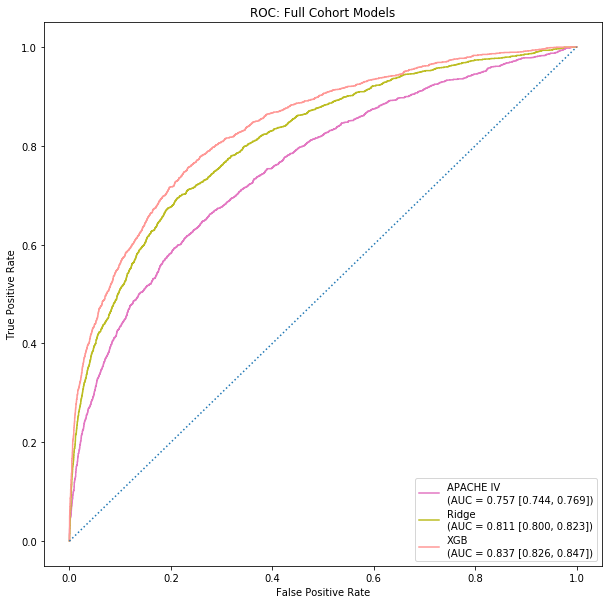

In [5]:
f_hat_apache = test_apache[test_apache > 0.10]
roc_apache = roc_curve(test_y_HR, f_hat_apache)
auc_apache = roc_auc_score(test_y_HR, f_hat_apache)

f_hat_ridge = ridge_classifier.predict_proba(test_X_HR)
roc_ridge = roc_curve(test_y_HR, f_hat_ridge[:, 1])
auc_ridge = roc_auc_score(test_y_HR, f_hat_ridge[:, 1])

f_hat_xgb = xgb_classifier.predict_proba(test_X_HR)
roc_xgb = roc_curve(test_y_HR, f_hat_xgb[:, 1])
auc_xgb = roc_auc_score(test_y_HR, f_hat_xgb[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(roc_apache[0], roc_apache[1], color=tableau20[12], 
         label='APACHE IV\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_apache, *auc_ci(f_hat_apache, test_y_HR)))
plt.plot(roc_ridge[0], roc_ridge[1], color=tableau20[16], 
         label='Ridge\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_ridge, *auc_ci(f_hat_ridge[:, 1], test_y_HR)))
plt.plot(roc_xgb[0], roc_xgb[1], color=tableau20[7], 
         label='XGB\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_xgb, *auc_ci(f_hat_xgb[:, 1], test_y_HR)))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Full Cohort Models')
plt.legend(loc="lower right")

plt.show()

__Calibration, Full Cohort Models__

We first calculate observed-to-predicted ratios.

In [6]:
print('Full Cohort Models: Observed-to-predicted Ratios')
print('Overall Subcohort Mortality: {0:.3f}'.format(test_y_HR.mean()))
print('APACHE IVa OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_apache.mean(), *op_ratio_ci(f_hat_apache, test_y_HR)))
print('Ridge OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_ridge[:, 1].mean(), *op_ratio_ci(f_hat_ridge[:, 1], test_y_HR)))
print('XGB OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_xgb[:, 1].mean(), *op_ratio_ci(f_hat_xgb[:, 1], test_y_HR)))

Full Cohort Models: Observed-to-predicted Ratios
Overall Subcohort Mortality: 0.214
APACHE IVa OPR: 0.694 [0.670, 0.720]
Ridge OPR: 1.104 [1.067, 1.143]
XGB OPR: 1.110 [1.073, 1.148]


We then generate reliability curves.

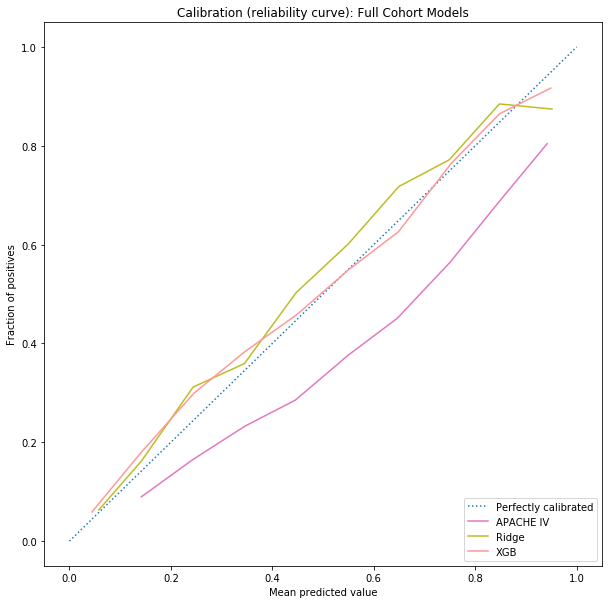

In [7]:
fraction_of_positives_apache, mean_predicted_value_apache = calibration_curve(test_y_HR, f_hat_apache, n_bins=10)
fraction_of_positives_ridge, mean_predicted_value_ridge = calibration_curve(test_y_HR, f_hat_ridge[:, 1], n_bins=10)
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(test_y_HR, f_hat_xgb[:, 1], n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[0])

ax1.plot(mean_predicted_value_apache, fraction_of_positives_apache, color=tableau20[12], 
         label='APACHE IV')
ax1.plot(mean_predicted_value_ridge, fraction_of_positives_ridge, color=tableau20[16], 
         label='Ridge')
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, color=tableau20[7], 
         label='XGB')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Calibration (reliability curve): Full Cohort Models')
ax1.set_xlabel("Mean predicted value")

plt.show()

__Brier Scores, Full Cohort Models__

In [8]:
bs_apache = brier_score_loss(test_y_HR, f_hat_apache)
bs_ridge = brier_score_loss(test_y_HR, f_hat_ridge[:, 1])
bs_xgb = brier_score_loss(test_y_HR, f_hat_xgb[:, 1])

print('Brier Scores for Full Cohort Models')
print('APACHE IV Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_apache, *brier_ci(f_hat_apache, test_y_HR)))
print('Ridge Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_ridge, *brier_ci(f_hat_ridge[:, 1], test_y_HR)))
print('XGB Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_xgb, *brier_ci(f_hat_xgb[:, 1], test_y_HR)))

Brier Scores for Full Cohort Models
APACHE IV Brier Score: 0.150 [0.146, 0.154]
Ridge Brier Score: 0.125 [0.120, 0.130]
XGB Brier Score: 0.117 [0.112, 0.122]


__Discrimination, High-risk Subset Models__

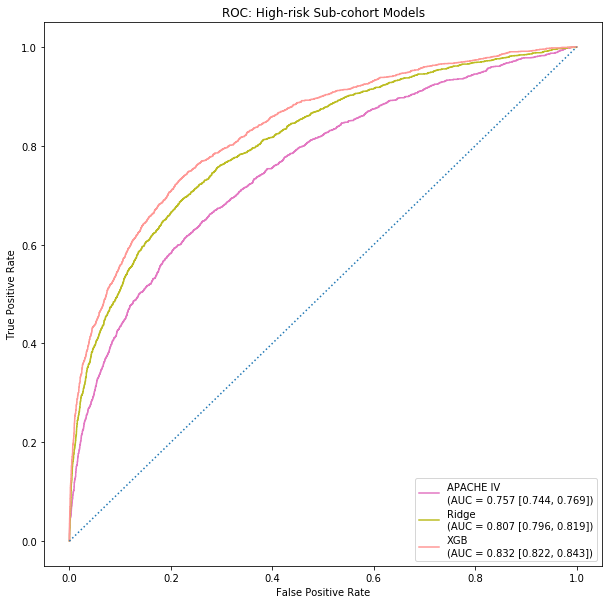

In [9]:
f_hat_ridge_HR = ridge_classifier_HR.predict_proba(test_X_HR)
roc_ridge_HR = roc_curve(test_y_HR, f_hat_ridge_HR[:, 1])
auc_ridge_HR = roc_auc_score(test_y_HR, f_hat_ridge_HR[:, 1])

f_hat_xgb_HR = xgb_classifier_HR.predict_proba(test_X_HR)
roc_xgb_HR = roc_curve(test_y_HR, f_hat_xgb_HR[:, 1])
auc_xgb_HR = roc_auc_score(test_y_HR, f_hat_xgb_HR[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(roc_apache[0], roc_apache[1], color=tableau20[12], 
         label='APACHE IV\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_apache, *auc_ci(f_hat_apache, test_y_HR)))
plt.plot(roc_ridge_HR[0], roc_ridge_HR[1], color=tableau20[16], 
         label='Ridge\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_ridge_HR, *auc_ci(f_hat_ridge_HR[:, 1], test_y_HR)))
plt.plot(roc_xgb_HR[0], roc_xgb_HR[1], color=tableau20[7], 
         label='XGB\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_xgb_HR, *auc_ci(f_hat_xgb_HR[:, 1], test_y_HR)))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: High-risk Sub-cohort Models')
plt.legend(loc="lower right")

plt.show()

__Calibration, High-risk Subset Models__

Again, we first produce observed-to-predicted ratios.

In [10]:
print('High-risk Sub-cohort Models: Observed-to-predicted Ratios')
print('Overall Subcohort Mortality: {0:.3f}'.format(test_y_HR.mean()))
print('APACHE IVa OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_apache.mean(), *op_ratio_ci(f_hat_apache, test_y_HR)))
print('Ridge OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_ridge_HR[:, 1].mean(), *op_ratio_ci(f_hat_ridge_HR[:, 1], test_y_HR)))
print('XGB OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_xgb_HR[:, 1].mean(), *op_ratio_ci(f_hat_xgb_HR[:, 1], test_y_HR)))

High-risk Sub-cohort Models: Observed-to-predicted Ratios
Overall Subcohort Mortality: 0.214
APACHE IVa OPR: 0.694 [0.670, 0.720]
Ridge OPR: 0.994 [0.959, 1.029]
XGB OPR: 1.033 [0.998, 1.068]


And then reliability curves for our high-risk models.

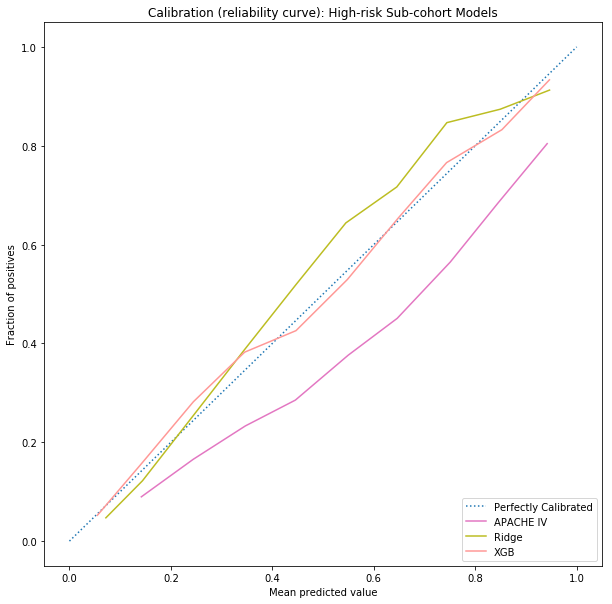

In [11]:
fraction_of_positives_ridge_HR, mean_predicted_value_ridge_HR = calibration_curve(test_y_HR, f_hat_ridge_HR[:, 1], n_bins=10)
fraction_of_positives_xgb_HR, mean_predicted_value_xgb_HR = calibration_curve(test_y_HR, f_hat_xgb_HR[:, 1], n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated", color=tableau20[0])

ax1.plot(mean_predicted_value_apache, fraction_of_positives_apache, color=tableau20[12], 
         label='APACHE IV')
ax1.plot(mean_predicted_value_ridge_HR, fraction_of_positives_ridge_HR, color=tableau20[16], 
         label='Ridge')
ax1.plot(mean_predicted_value_xgb_HR, fraction_of_positives_xgb_HR, color=tableau20[7], 
         label='XGB')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Calibration (reliability curve): High-risk Sub-cohort Models')
ax1.set_xlabel("Mean predicted value")

plt.show()

__Brier Scores, High-risk Subset__

In [12]:
bs_ridge_HR = brier_score_loss(test_y_HR, f_hat_ridge_HR[:, 1])
bs_xgb_HR = brier_score_loss(test_y_HR, f_hat_xgb_HR[:, 1])

print('Brier Scores for High-risk Subcohort Models')
print('APACHE IV Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_apache, *brier_ci(f_hat_apache, test_y_HR)))
print('Ridge Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_ridge_HR, *brier_ci(f_hat_ridge_HR[:, 1], test_y_HR)))
print('XGB Brier Score: {0:.3f} [{1:.3f}, {2:.3f}]'.format(bs_xgb_HR, *brier_ci(f_hat_xgb_HR[:, 1], test_y_HR)))

Brier Scores for High-risk Subcohort Models
APACHE IV Brier Score: 0.150 [0.146, 0.154]
Ridge Brier Score: 0.126 [0.122, 0.131]
XGB Brier Score: 0.117 [0.113, 0.122]


## 3 - Feature Analysis

The features of the ridge models may be examined via the odds ratios associated with each feature. Similary, although not directly comparable, the importance matrix of the gradient boosted models may provide insight.

We first extract the feature names.

In [13]:
feature_names = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').columns

For the ridge models, we'll manually extract the coefficient array, which has its order preserved, and assign the feature names so that we can easily read the sorted list. We examine the full cohort model first.

In [14]:
ridge_coef = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier.named_steps['ridge'].coef_.ravel())}
ridge_coef = pd.DataFrame.from_dict(ridge_coef, orient='index', columns=['odds_ratio'])
ridge_coef.reindex(ridge_coef.odds_ratio.abs().sort_values(ascending=False).index).iloc[0:20, :]

,odds_ratio
age,1.349667
hr_mean,1.227071
rr_mean,1.220041
adx_CARDARREST,1.206206
adx_ICH,1.184088
adx_CVASTROKE,1.175503
lactate_max,1.170366
apache_ventday1,1.158545
apache_active_tx,1.132817
pressor,1.121750


And then we turn to the subcohort model.

In [15]:
ridge_coef_HR = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier_HR.named_steps['ridge'].coef_.ravel())}
ridge_coef_HR = pd.DataFrame.from_dict(ridge_coef_HR, orient='index', columns=['odds_ratio'])
ridge_coef_HR.reindex(ridge_coef_HR.odds_ratio.abs().sort_values(ascending=False).index).iloc[0:20, :]

,odds_ratio
adx_CARDARREST,1.203058
lactate_max,1.185894
age,1.177680
hr_mean,1.173397
rr_mean,1.171245
adx_ICH,1.143109
pressor,1.134550
apache_ventday1,1.117141
apache_active_tx,1.097039
adx_CVASTROKE,1.094518


The top 20 features in both by OR magnitude are similar for both the full and subcohort models, and, intuitevly we note certain features in the high-risk model that we would expect to see with more prevalence in a sicker cohort e.g. metastasis (`mets`).

We next turn to the XGB models. For these we'll need to map the feature names onto the models internal representation of the features and thene xtract the importance matrices. Again we start with the full cohort models. XGB also provides a nice function for visualizing the matrix.

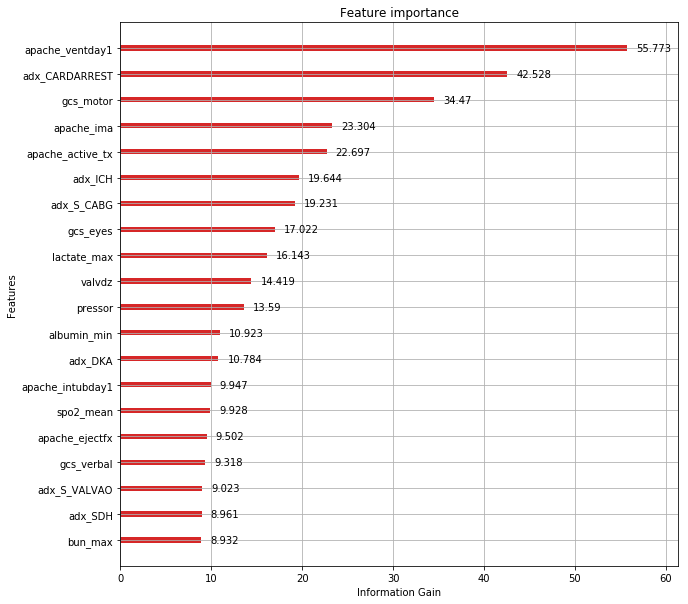

In [16]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', xlabel='Information Gain', ax=plt.axes())
plt.show()

Using the same mapper, we can generate the same result for the high-risk subcohort XGB model.

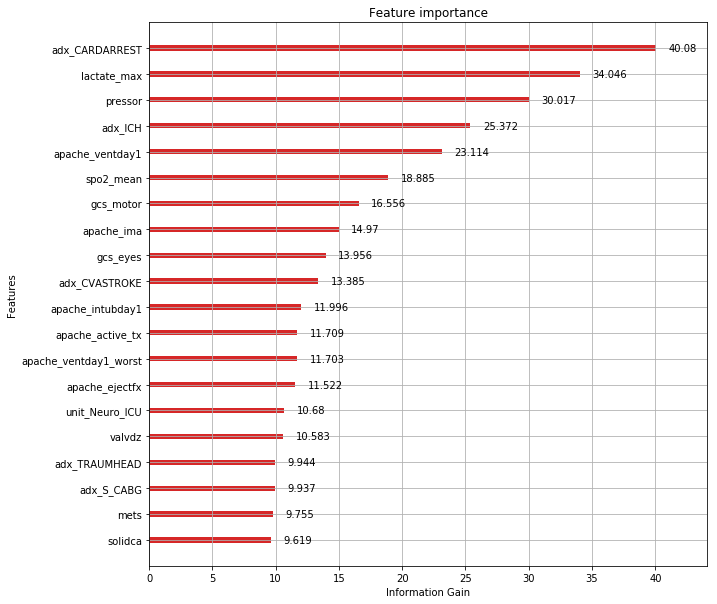

In [17]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier_HR.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', xlabel='Information Gain', ax=plt.axes())
plt.show()

We note similarity between these features and the ridge features and substantial overlap between the XGB full and high-risk models. Overall we have a pretty good intuition as to why these are the biggest contributions, and differences between full and high-risk subcohort models are not marked.